# exp008
elapsed_timeのmax, min

In [13]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp008"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.6 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [15]:
params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.1, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed, 
    'feature_pre_filter': False, 
    'lambda_l1': 3.86172588734434e-05, 
    'lambda_l2': 8.164200511365216, 
    'num_leaves': 31, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.9437148886789388, 
    'bagging_freq': 1, 
    'min_child_samples': 50
}

In [16]:
event_name_list = [
    'cutscene_click', 'person_click', 'navigate_click',
    'observation_click', 'notification_click', 'object_click',
    'object_hover', 'map_hover', 'map_click', 'checkpoint',
    'notebook_click'
]

name_list = [
    'basic', 'undefined', 'close', 'open', 'prev', 'next'
]

In [17]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [18]:
class Features:
    def __init__(self, sessions):
        self.sessions = sessions.copy()
        self.features = sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _lg_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"lg_record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_event_name_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for event in event_name_list:
            new_col = f"lg_{event}_record_cnt"
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _lg_name_record_cnt(self):
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for name in name_list:
            new_col = f"lg_{name}_record_cnt"
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _lg_elapsed_time(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index().rename(columns={"max":"lg_elapsed_time_max", "min":"lg_elapsed_time_min"})
        add_features["lg_elapsed_time_max_min"] = add_features["lg_elapsed_time_max"] - add_features["lg_elapsed_time_min"]
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_coor_mean(self):
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"lg_room_coor_x_mean", "room_coor_y":"lg_room_coor_y_mean", "screen_coor_x":"lg_screen_coor_x_mean", "screen_coor_y":"lg_screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _lg_text_nunique(self):
        add_features = self.sessions.dropna(subset="text").drop_duplicates(["session_id", "level_group", "text"])
        add_features = add_features.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"lg_text_nunique"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def get_features(self):
        self._lg_record_cnt()
        self._lg_event_name_record_cnt()
        self._lg_name_record_cnt()
        self._lg_elapsed_time()
        self._lg_coor_mean()
        self._lg_text_nunique()
        return self.features

In [19]:
def calc_metrics(oof):
    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_threshold

In [20]:
def get_train_data(sessions, labels):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype("category")
    train["question"] = train["question"].astype("category")

    return train

In [21]:
def run_train():
    # データ読み込み
    train_sessions = pd.read_csv(cfg.input_dir + "train.csv")
    labels = pd.read_csv(cfg.input_dir + "train_labels.csv")
    
    train = get_train_data(train_sessions, labels)

    target = "correct"
    not_use_cols = [target, "session_id"]
    features = [c for c in train.columns if c not in not_use_cols]

    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        # モデル出力
        model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb")
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = model.feature_name()
        fi_fold["importance"] = model.feature_importance(importance_type="gain")
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof.to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip")

In [22]:
def get_mock_iter_test():
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [23]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
    
    for (sample_submission, test_sessions) in iter_test:
        test = get_train_data(test_sessions, sample_submission)
        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            if mode == "local_cv":
                model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
            elif mode == "kaggle_inf":
                model_path = f"/kaggle/input/jo-wilder-exp002/exp002_model{i}.lgb"
            model = lgb.Booster(model_file=model_path)
            features = model.feature_name()
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)

fold : 0
[LightGBM] [Info] Number of positive: 119434, number of negative: 50180


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4216
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704152 -> initscore=0.867147
[LightGBM] [Info] Start training from score 0.867147
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.490336	valid_1's binary_logloss: 0.498374
[200]	training's binary_logloss: 0.479315	valid_1's binary_logloss: 0.497973
[300]	training's binary_logloss: 0.470227	valid_1's binary_logloss: 0.497893
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.473181	valid_1's binary_logloss: 0.497735
fold : 1


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Info] Number of positive: 119268, number of negative: 50346
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4219
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703173 -> initscore=0.862454
[LightGBM] [Info] Start training from score 0.862454
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.489489	valid_1's binary_logloss: 0.501811
[200]	training's binary_logloss: 0.478296	valid_1's binary_logloss: 0.501937
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.484938	valid_1's binary_logloss: 0.501641
fold : 2
[LightGBM] [Info] Number of positive: 119502, number of negative: 50112
[LightGBM] [Warning] Auto-choo

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704553 -> initscore=0.869073
[LightGBM] [Info] Start training from score 0.869073
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.488075	valid_1's binary_logloss: 0.506522
[200]	training's binary_logloss: 0.476838	valid_1's binary_logloss: 0.506652
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.486224	valid_1's binary_logloss: 0.506327
fold : 3


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Info] Number of positive: 119476, number of negative: 50138
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4215
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704399 -> initscore=0.868336
[LightGBM] [Info] Start training from score 0.868336
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.489343	valid_1's binary_logloss: 0.502755
[200]	training's binary_logloss: 0.478107	valid_1's binary_logloss: 0.502424
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.481715	valid_1's binary_logloss: 0.502313
fold : 4
[LightGBM] [Info] Number of positive: 119328, number of negative: 50304
[LightGBM] [Warning] Auto-choo

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513:

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703452 -> initscore=0.863791
[LightGBM] [Info] Start training from score 0.863791
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.488812	valid_1's binary_logloss: 0.503868
[200]	training's binary_logloss: 0.477666	valid_1's binary_logloss: 0.503724
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.481603	valid_1's binary_logloss: 0.503559
best_score 0.677509
best_threshold 0.630
------------------------------
Q1 : F1 = 0.507900
Q2 : F1 = 0.494572
Q3 : F1 = 0.530069
Q4 : F1 = 0.595041
Q5 : F1 = 0.315759
Q6 : F1 = 0.573619
Q7 : F1 = 0.492892
Q8 : F1 = 0.292047
Q9 : F1 = 0.502755
Q10 : F1 = 0.334330
Q11 : F1 = 0.316189
Q12 : F1 = 0.568884
Q13 : F1 = 0.421804
Q14 : F1 = 0.433051
Q15 : F1 = 0.341009
Q16 : F1 = 0.305135
Q17 : F1 = 0.279608
Q18 : F1 = 0.570413
[1 1 1]
[1 0 1 1 1]
[1 0 1 1 0 1 0 0 1 0]
[1 1 1]
[0 0 1 0 1]
[0 0 0 0 0 0 0 0 1 0]
[1 1 1]
[1 0 1 1 1]
[1 0 1 1 1 1 

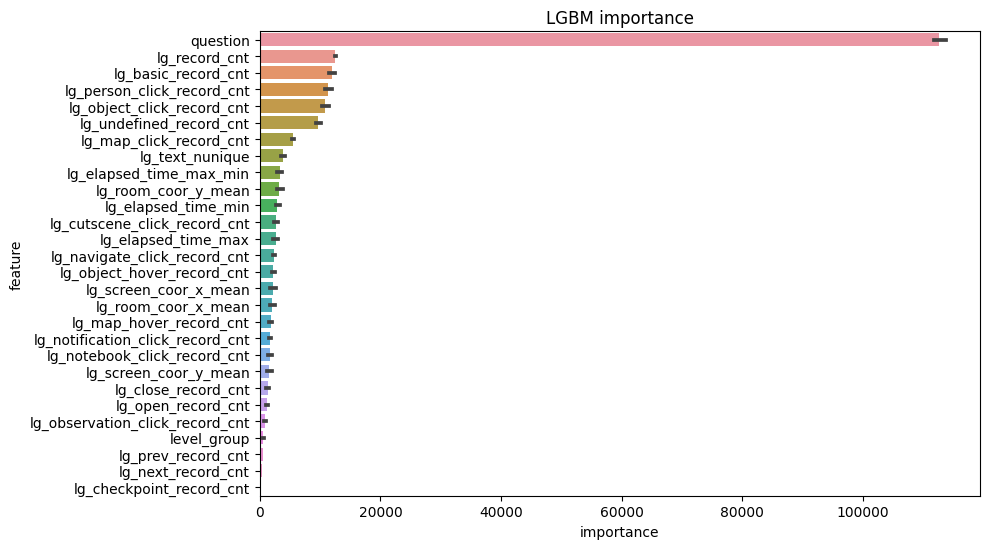

In [24]:
if cfg.mode == "local_cv":
    run_train()
inference(cfg.mode)